In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trainer
from trainer import device

In [4]:
import os
import PIL.Image

class ImageDataset(D.Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.files = [root + "/" + f for root, _, files in os.walk(path) for f in files]
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = PIL.Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, img

In [5]:
def display(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')

def displayn(imgp):
    f, ax = plt.subplots(1, len(imgp), figsize=(3*len(imgp),3))
    for i, (img, label) in enumerate(imgp):
        ax[i].set_title(label)
        ax[i].imshow(img.permute(1,2,0))
        ax[i].axis('off')

In [6]:
import torchvision.transforms as T

def img_resize(img):
    img = T.functional.to_tensor(img)
    img = T.functional.resize(img, 256, antialias=False)
    img = T.functional.pad(img, 64, padding_mode='edge')
    img = T.functional.center_crop(img, 256)
    return img

dataset = ImageDataset('../img_align_celeba', transform=lambda img: img_resize(img))

In [7]:
class FaceGen(nn.Module):
    def __init__(self, n_hidden=256, n_embed=128):
        super().__init__()
        assert(n_hidden % 8 == 0)
        self.decoder = nn.Sequential(
            nn.Linear(n_embed, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, 8*8*n_hidden),
            nn.ReLU(inplace=True),
            nn.Unflatten(-1, (n_hidden, 8, 8)),
            # 8^2 => 16^2
            nn.ConvTranspose2d(n_hidden, n_hidden, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 16^2 => 32^2
            nn.ConvTranspose2d(n_hidden, n_hidden, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 32^2 => 64^2
            nn.ConvTranspose2d(n_hidden//2, n_hidden//2, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//2, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden//2, n_hidden//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 64^2 => 128^2
            nn.ConvTranspose2d(n_hidden//4, n_hidden//4, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//4, n_hidden//8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 128^2 => 256^2
            nn.ConvTranspose2d(n_hidden//8, n_hidden//8, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//8, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid() # => 0..1
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [8]:
class FaceSus(nn.Module):
    def __init__(self, n_hidden=256):
        super().__init__()
        assert(n_hidden % 8 == 0)
        self.encoder = nn.Sequential(
            # 256^2 => 128^2
            nn.Conv2d(3, n_hidden//8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 128^2 => 64^2
            nn.Conv2d(n_hidden//8, n_hidden//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64^2 => 32^2
            nn.Conv2d(n_hidden//4, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden//2, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32^2 => 16^2
            nn.Conv2d(n_hidden//2, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 16^2 => 8^2
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8^2 => embedding
            nn.Flatten(-3), # BxCxHxW => BxC*H*W
            nn.Linear(8*8*n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [9]:
n_embed = 128
gen = FaceGen(n_embed=n_embed).to(device)
sus = FaceSus().to(device)

def train(batch_size, batch_iter, train_iter):
    data = D.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    datait = iter(data)

    opt_gen = torch.optim.AdamW(gen.parameters())
    opt_sus = torch.optim.AdamW(sus.parameters())

    ones = torch.ones((batch_size, 1)).to(device)
    zeros = torch.zeros((batch_size, 1)).to(device)

    for i in range(train_iter):
        sus.train()
        gen.eval()
        for k in range(batch_iter):

            with torch.no_grad():
                z = torch.randn((batch_size, n_embed)).to(device)
                y = gen(z)
                x = next(datait)[0].to(device)

            loss_x = F.binary_cross_entropy_with_logits(sus(x), ones)
            loss_y = F.binary_cross_entropy_with_logits(sus(y), zeros)
            loss_sus = loss_y + loss_x # this will need to change if we use batchnorm

            opt_sus.zero_grad()
            loss_sus.backward()
            opt_sus.step()

        gen.train()
        sus.eval()

        z = torch.randn((batch_size, n_embed)).to(device)
        y = gen(z)

        loss_gen = F.binary_cross_entropy_with_logits(sus(y), ones)

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if i % 10 == 0:
            print(f'[{i}/{train_iter}] D loss: {loss_sus.item():.3f}; G loss: {loss_gen.item():.3f}')


train(batch_size = 32, batch_iter = 5, train_iter = 1000)

[0/1000] D loss: 1.259; G loss: 0.537
[10/1000] D loss: 3.169; G loss: 0.058
[20/1000] D loss: 0.985; G loss: 2.821
[30/1000] D loss: 1.197; G loss: 0.538
[40/1000] D loss: 0.098; G loss: 8.335
[50/1000] D loss: 0.035; G loss: 4.932
[60/1000] D loss: 0.011; G loss: 8.166
[70/1000] D loss: 0.000; G loss: 10.416
[80/1000] D loss: 0.000; G loss: 11.483
[90/1000] D loss: 0.000; G loss: 13.554
[100/1000] D loss: 0.000; G loss: 14.223
[110/1000] D loss: 0.000; G loss: 14.666
[120/1000] D loss: 0.000; G loss: 14.979


KeyboardInterrupt: 

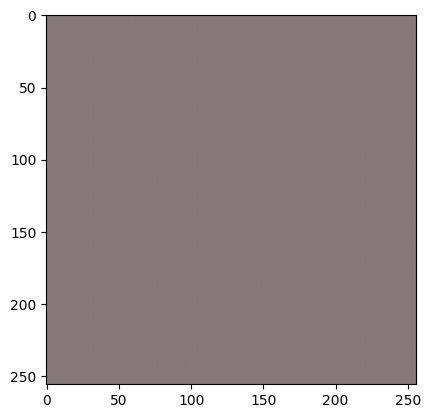

In [ ]:
plt.imshow(gen(torch.randn((1, n_embed)).to(device)).cpu().detach().squeeze().permute(1, 2, 0))

In [ ]:
sus(dataset[4][0].to(device))

tensor([-1877.4258], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
sus(gen(torch.randn((1, n_embed)).to(device)))

tensor([[-3.2593]], device='cuda:0', grad_fn=<AddmmBackward0>)